In [ ]:
import random
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

class agent:
    def __init__(self, data, number_of_params = 3, repetitions = 1000, make_graph = False, loo=False):
        self.data = data
        self.number_of_params = number_of_params
        self.repetitions = repetitions
        self.used_params = []
        self.results = []
        self.make_graph = make_graph
        self.size = self.data.shape[0]
        self.loo = loo
        self.run()


    def run(self):

        for i in tqdm(range(self.repetitions), desc="Procesando", unit="iteración"):
        # for i in range(self.repetitions):
          if self.loo:
            ids = self.select_params(self.number_of_params)
            errors, division, zero_is_up = self.calculate_loo(ids)
            self.results.append({"Error": errors, "IDs":ids, "Division": division, "Zero_Over": zero_is_up})
            self.results = sorted(self.results,key=lambda x: x['Error'])


            if errors < 1:
              print("Error less than 1")
              print (self.results[0]['Error'])
              print (self.results[0]['IDs'])
              break

            if len(self.used_params) > math.factorial(self.data.shape[0]) // (math.factorial(self.number_of_params) * math.factorial(self.data.shape[1] - self.number_of_params)):
              print("There are no more possible combinations")
              print (self.results[0]['Error'])
              print (self.results[0]['IDs'])
              break


          else:
            ids = self.select_params(self.number_of_params)
            mean, division, y, errors, is_zero_over = self.calculate(ids)
            self.results.append({"Error": errors,"Mean": mean, "y":y,  "IDs":ids, "Division":division, "Is Zero Over": is_zero_over})
            self.results = sorted(self.results,key=lambda x: x['Error'])

            if errors == 0:
              print("Error is 0")
              break

            if len(self.used_params) > math.factorial(self.data.shape[1]):
              print("There are no more possible combinations")
              break


        if self.make_graph:
          self.graph(self.results[0]["Mean"], self.results[0]["Division"], self.results[0]["y"])
            # print (self.results[0]['Error'])
            # print (self.results[0]['IDs'])
            # print (self.results[0]['Division'])


    def select_params(self, number):
        ids = random.choices(range(0, self.data.shape[1]-1), k=self.number_of_params)
        ids.sort()
        while ids in self.used_params:
          ids = random.choices(range(0, self.data.shape[1]), k=self.number_of_params)
          ids.sort()
        self.used_params.append(ids)
        return ids

    def calculate(self, ids):
        #Select the data
        ids.append(self.data.columns.size-1)
        subset = self.data.iloc[:, ids]
        X = subset.iloc[:, 0:self.number_of_params]
        y = subset.iloc[:, self.number_of_params]
        #Calculate mean and std
        mean = X.mean(axis=1)
        # vals = list(range(1,int(self.size/2)+1))*2
        result_subset = pd.DataFrame({"mean":mean,"y":y})
        result_subset_0 = result_subset[result_subset["y"] == 0]
        result_subset_1 = result_subset[result_subset["y"] == 1]
        mean_0 = result_subset_0["mean"].mean()
        mean_1 = result_subset_1["mean"].mean()


        if mean_0 > mean_1:
            zero_is_up = True
            division = (max(result_subset_1["mean"]) + min(result_subset_0["mean"]))/2
        else:
            zero_is_up = False
            division = (max(result_subset_0["mean"]) + min(result_subset_1["mean"]))/2
        errors = self.evaluate(result_subset, division, zero_is_up)
        return mean, division, y, errors, zero_is_up

    def calculate_loo(self, ids):
      ids.append(self.data.columns.size-1)
      errors = 0
      for i in range(self.size):
        subset = self.data.iloc[:, ids]
        test = subset.iloc[i, :]
        subset = subset.drop(subset.index[i])
        X = subset.iloc[:, 0:self.number_of_params]
        y = subset.iloc[:, self.number_of_params]
        mean = X.mean(axis=1)
        result_subset = pd.DataFrame({"mean":mean,"y":y})
        result_subset_0 = result_subset[result_subset["y"] == 0]
        result_subset_1 = result_subset[result_subset["y"] == 1]
        mean_0 = result_subset_0["mean"].mean()
        mean_1 = result_subset_1["mean"].mean()
        if mean_0 > mean_1:
            zero_is_up = True
            division = (max(result_subset_1["mean"]) + min(result_subset_0["mean"]))/2
        else:
            zero_is_up = False
            division = (max(result_subset_0["mean"]) + min(result_subset_1["mean"]))/2
        mean_test= test.iloc[0:self.number_of_params].mean()
        y_test = test.iloc[-1]
        errors += self.evaluate_loo(mean_test, y_test, division, zero_is_up)

      subset = self.data.iloc[:, ids]
      X = subset.iloc[:, 0:self.number_of_params]
      y = subset.iloc[:, self.number_of_params]
      mean = X.mean(axis=1)
      result_subset = pd.DataFrame({"mean":mean,"y":y})
      result_subset_0 = result_subset[result_subset["y"] == 0]
      result_subset_1 = result_subset[result_subset["y"] == 1]
      mean_0 = result_subset_0["mean"].mean()
      mean_1 = result_subset_1["mean"].mean()
      if mean_0 > mean_1:
          zero_is_up = True
          division = (max(result_subset_1["mean"]) + min(result_subset_0["mean"]))/2
      else:
          zero_is_up = False
          division = (max(result_subset_0["mean"]) + min(result_subset_1["mean"]))/2

      return errors, division, zero_is_up



    def evaluate(self, result_subset, division, zero_is_up):
        errors = 0
        for index, row in result_subset.iterrows():
            if zero_is_up == False:
              if row["y"] == 0:
                  if row["mean"] > division:
                      errors += 1
              else:
                  if row["mean"] < division:
                      errors += 1
            else:
              if row["y"] == 0:
                  if row["mean"] < division:
                      errors += 1
              else:
                  if row["mean"] > division:
                      errors += 1
        return errors

    def evaluate_loo(self, mean, y, division, zero_is_up):
      if zero_is_up == False:
          if y == 0:
              if mean > division:
                  return 1
          else:
              if mean < division:
                  return 1
      else:
          if y == 0:
              if mean < division:
                  return 1
          else:
              if mean > division:
                  return 1
      return 0




    def mutate(self):
        pass


    def graph(self, mean, division, y):
        colors = {
            0: 'blue',
            1: 'yellow',
            # Agrega más clases y colores según tus necesidades
        }
        # vals = list(range(1,int(self.size/2)+1))*2
        vals = list(range(1,len(mean)+1))
        colors_points = [colors[clase] for clase in y]
        plt.scatter(vals, mean, c=colors_points)
        plt.xlabel('Valores')
        plt.ylabel('Media')

        plt.axhline(y=division, color='black', linewidth=1)

        # Muestra la leyenda para las clases
        for clase, color in colors.items():
            plt.scatter([], [], c=color, label=clase)

        plt.legend()

        # Muestra el gráfico
        plt.show()

    def graph_prediction(self, mean, division, y, points):
        colors = {
            0: 'blue',
            1: 'yellow',

            # Agrega más clases y colores según tus necesidades
        }
        vals = list(range(1,int(self.size/2)+1))*2
        colors_points = [colors[clase] for clase in y]
        plt.scatter(vals, mean, c=colors_points)
        for i in range(1, len(points)+1):
           color = points[i-1][1]
           if color == True:
              color_point = 'green'
           else:
              color_point = 'red'
           plt.scatter(i, points[i-1][0], c=color_point)

        plt.xlabel('Valores')
        plt.ylabel('Media')

        plt.axhline(y=division, color='black', linewidth=1)

        # Muestra la leyenda para las clases
        for clase, color in colors.items():
            plt.scatter([], [], c=color, label=clase)

        plt.legend()

        # Muestra el gráfico
        plt.show()

    def test(self, data_to_test, plot=True):
        print (self.results[0]['Error'])
        print (self.results[0]['IDs'])
        print (self.results[0]['Division'])
        points=[]
        data_to_test = data_to_test.iloc[: , self.results[0]['IDs']]
        for index, row in data_to_test.iterrows():
              row = row.tolist()
              X = row[:-1]
              y=row[-1]
              # print(f'X: {X}')
              # print(f'y: {y}')
              mean_test = np.mean(X)
              # print(f'mean_test: {mean_test}')

              prediction = None
              if mean_test > self.results[0]["Division"]:
                  if self.results[0]["Is Zero Over"] == True:
                      prediction = 0
                  else:
                      prediction = 1
              else:
                  if self.results[0]["Is Zero Over"] == True:
                      prediction = 1
                  else:
                      prediction = 0

              print(f'Predicción: {prediction}')
              print(f'Real: {y}')
              points.append([mean_test, y==int(prediction)])
        if plot:
            self.graph_prediction(self.results[0]["Mean"], self.results[0]["Division"], self.results[0]["y"], points)
        return points




In [ ]:
import random
from tqdm import tqdm
import math
import matplotlib.pyplot as plt


def test_loo( data, IDs):
  errors_found= []
  size = data.shape[0]
  errors = 0
  for i in range(size):
    test = data.iloc[i, IDs]
    subset = data.drop(data.index[i])
    subset = subset.iloc[:, IDs]
    X = subset.iloc[:, 0:-1]
    y = subset.iloc[:, -1]

    mean = X.mean(axis=1)
    result_subset = pd.DataFrame({"mean":mean,"y":y})
    result_subset_0 = result_subset[result_subset["y"] == 0]
    result_subset_1 = result_subset[result_subset["y"] == 1]
    mean_0 = result_subset_0["mean"].mean()
    mean_1 = result_subset_1["mean"].mean()

    if mean_0 > mean_1:
        zero_is_up = True
        division = (max(result_subset_1["mean"]) + min(result_subset_0["mean"]))/2
    else:
        zero_is_up = False
        division = (max(result_subset_0["mean"]) + min(result_subset_1["mean"]))/2
    mean_test = test.iloc[0:-1].mean()
    y_test = test.iloc[-1]
    is_err, err_id =evaluate_loo(i, mean_test, y_test, division, zero_is_up)
    errors += is_err
    if is_err == 1:
      errors_found.append(err_id)
  return errors, errors_found


def evaluate_loo(i, mean, y, division, zero_is_up):

  if zero_is_up == False:
      if y == 0:
          if mean > division:
              print("Error in index", i, ":" ,mean, y, division, zero_is_up)
              return 1, i

      else:
          if mean < division:
              print("Error in index", i, ":" ,mean, y, division, zero_is_up)
              return 1,i
  else:
      if y == 0:
          if mean < division:
              print("Error in index", i, ":" ,mean, y, division, zero_is_up)
              return 1, i
      else:
          if mean > division:
              print("Error in index", i, ":" ,mean, y, division, zero_is_up)
              return 1, i
  return 0, None





In [ ]:
import pandas as pd
import numpy as np
##NUTT
# data = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/MML/data/Nutt.csv", header=None)

#IRIS
# dataset_url = "https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv"
# iris_df = pd.read_csv(dataset_url)
# iris_df['species'] = iris_df['species'].map({'setosa': 2, 'versicolor': 0, 'virginica': 1})
# data = iris_df[iris_df['species'] != 2]

# haberman NO!!!
# data = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/MML/data/haberman_survival.csv", header=None)
# last_column = data.columns[-1]
# data[last_column] = data[last_column].replace({1: 0, 2: 1})

# heart
data = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/MML/data/heart-statlog_csv.csv")
last_column = data.columns[-1]
data[last_column] = data[last_column].replace({"absent": 0, "present": 1})

#breast cancer
# data = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/MML/data/wdbc.csv", header=None)
# data = data.iloc[:, 1:]
# data = pd.concat([data, data.iloc[:, 0]], axis=1)
# data = data.iloc[:, 1:]
# last_column = data.columns[-1]
# data[last_column] = data[last_column].replace({'M': 0, 'B': 1})

#mamographic masses NO!!!
# data = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/MML/data/mammographic_masses.csv", header=None,  sep=';')
# data.replace('?', np.nan, inplace=True)
# data.dropna(inplace=True)

#data banknote autentication NO!!!
# data = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/MML/data/data_banknote_authentication.csv", header=None, sep=';')
# data = data.drop(293)
# data.head()

#ionosphere
# data = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/MML/data/ionosphere.csv", header=None, sep=';')
# last_column = data.columns[-1]
# data[last_column] = data[last_column].replace({'g': 0, 'b': 1})

#trasnfusion
# data = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/MML/data/transfusion.csv")
# data.head()

#bupa
# data = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/MML/data/bupa.csv", header=None, sep=';')
# last_column = data.columns[-1]
# data[last_column] = data[last_column].replace({1: 0, 2: 1})

#rice cammeo
# data = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/MML/data/Rice_Cammeo_Osmancik.csv", header=None,)
# last_column = data.columns[-1]
# data[last_column] = data[last_column].replace({"Cammeo": 0, "Osmancik": 1})

# #wine
# data = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/MML/data/wine.csv", header=None)
# # data = data.iloc[:, 1:]
# data = pd.concat([data, data.iloc[:, 0]], axis=1)
# data = data.iloc[:, 1:]
# last_column = data.columns[-1]
# #remove all rows with 3 in last column
# data = data[data[last_column] != 3]
# data[last_column] = data[last_column].replace({1: 0, 2: 1})
# # data[last_column] = data[last_column].replace({1: 0, 2: 0, 3: 1})

# data.head()
# data.shape
#show number of each class
# print(data[last_column].value_counts())

# last_column = data.columns[0]
# data[last_column] = data[last_column].replace({"M": 0, "B": 1})

# index_to_test = np.random.choice(data.shape[0], size=2, replace=False)
# test_data = data.iloc[index_to_test]
# train_data = data.drop(index_to_test)
# train_data = data
# print(test_data)








In [ ]:
data.to_csv('heart_export.csv', index=False)

In [ ]:
def classify(agents, item):
  classification = []
  for agent in agents:
    ids_classify = agent.results[0]['IDs']

    item_mean = item.iloc[ids_classify].mean()
    print(agent.results[0]["Division"],item_mean)
    if agent.results[0]["Zero_Over"] == False:
      if item_mean > agent.results[0]["Division"]:
        classification.append(1)
      else:
        classification.append(0)
    else:
      if item_mean > agent.results[0]["Division"]:
        classification.append(0)
      else:
        classification.append(1)
    return classification




Procesando: 100%|██████████| 2000/2000 [01:09<00:00, 28.58iteración/s]


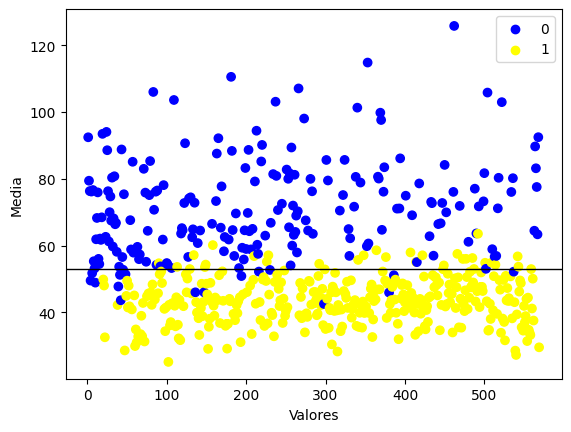

Procesando: 100%|██████████| 2000/2000 [01:10<00:00, 28.57iteración/s]


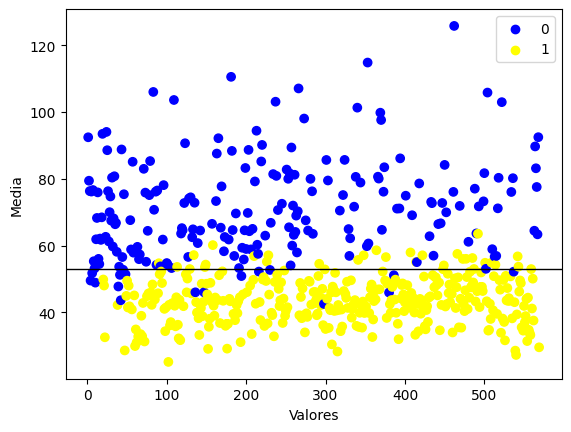

Procesando: 100%|██████████| 2000/2000 [01:12<00:00, 27.76iteración/s]


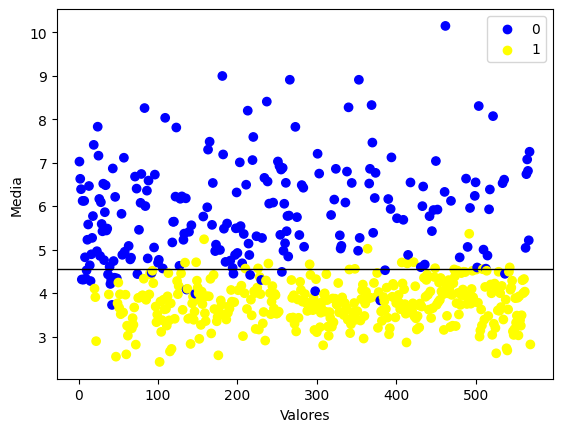

--- 213.05587816238403 seconds ---


In [ ]:
import time
start_time = time.time()
agentes = []
num_of_agents = 3
for i in range(num_of_agents):
  charact = random.randint(2, 4)
  agentes.append(agent(data, charact, repetitions = 2000, make_graph = True, loo=False))

# Check if all agentes are diferents
if num_of_agents > 1:
  for i in range(num_of_agents):
    for j in range(i, num_of_agents):
        if agentes[i].results[0]['IDs']== agentes[j].results[0]['IDs']:
          agentes[j].results.pop(0)

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
from re import T
count_errors = {}
for agente in agentes:
  print("IDs: ",agente.results[0]['IDs'])
  print("Errores: ",agente.results[0]['Error'])
  print("Division: ",agente.results[0]['Division'])
  num_err, id_err = test_loo(data, agente.results[0]['IDs'])
  #count the times a number is repeated in errores

  for item in id_err:
    if item in count_errors:
      count_errors[item] += 1
    else:
      count_errors[item] = 1
cant_errors = 0
errors_type1_type2 = [0, 0]
for key, value in count_errors.items():
  if value > len(agentes)/2:
    type_error = data.iloc[key, -1]
    errors_type1_type2[type_error] += 1
    print(f"Error {key}: {value} veces", "Debería haber sido:", type_error )
print(f"Total de errores tipo 0: {errors_type1_type2[0]}")
print(f"Total de errores tipo 1: {errors_type1_type2[1]}")

IDs:  [22, 28, 30]
Errores:  45
Division:  53.144025
Error in index 3 : 49.7669 0.0 53.144025 True
Error in index 5 : 51.89925 0.0 53.144025 True
Error in index 9 : 49.0433 0.0 53.144025 True
Error in index 38 : 47.84825 0.0 53.144025 True
Error in index 40 : 51.3997 0.0 53.144025 True
Error in index 41 : 43.7582 0.0 53.144025 True
Error in index 44 : 52.93465 0.0 53.144025 True
Error in index 47 : 51.595 0.0 53.144025 True
Error in index 89 : 54.85755 1.0 53.144025 True
Error in index 112 : 53.6199 1.0 53.144025 True
Error in index 133 : 57.28615 1.0 53.144025 True
Error in index 135 : 46.16145 0.0 53.144025 True
Error in index 146 : 46.2537 0.0 53.144025 True
Error in index 147 : 53.6926 1.0 53.144025 True
Error in index 148 : 54.434549999999994 1.0 53.144025 True
Error in index 157 : 60.27635 1.0 53.144025 True
Error in index 193 : 51.01075 0.0 53.144025 True
Error in index 209 : 56.966 1.0 53.144025 True
Error in index 215 : 52.3815 0.0 53.144025 True
Error in index 225 : 55.353100

In [ ]:
test_loo(data, [158, 185, 379, 632, 1070])

IndexError: positional indexers are out-of-bounds

In [ ]:
for i in range(len(test_data)):
  item = test_data.iloc[i]
  # print(item)

  classification = classify(agentes, item)
  print(classification, test_data.iloc[i,-1])

NameError: name 'test_data' is not defined

In [ ]:
for agente in agentes:
  agente.test(test_data)
# agente_2.test(test[0])
# agente_3.test(test[0])

NameError: name 'test_data' is not defined